In [726]:
#Lots to import!
import time
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd
import os
from bs4 import BeautifulSoup
import requests
import csv
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from basketball_reference_web_scraper import client
from datetime import date
from functools import reduce
from datetime import datetime
from collections import Counter
from dateutil.rrule import rrule, DAILY
from basketball_reference_web_scraper import client
from basketball_reference_web_scraper.data import Team
from basketball_reference_web_scraper.data import Outcome
from basketball_reference_web_scraper.data import Position

In [727]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [728]:
#Load our two big datasets the full one from 1988-2019, and the subset from 2000-2019 which includes the leaderdata

all_data = pd.read_csv("output/full_dataframe.csv").set_index("Player")

all_data_2000 = pd.read_csv("output/full_df_leaderdata.csv").set_index("Player")

In [729]:
#First linear regression including all variables that might have an influence in MVP share.
#Note: I'm starting out with the most basic (worst) model possible
#To begin to illustrate the process of predicting the MVP with these datasets, then will iteratively improve.

X=all_data[['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
       'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
       'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'Year', 'box', 'eFG%',
        'gp_pct', 'playoffs', 'seed']]

for i in X:
    if X[i].isnull().values.any():
        X[i]=X[i].fillna(0)

X_test=X[X["Year"]==2019]
X=X[X["Year"]!=2019]
y=all_data[all_data["Year"]!=2019]["Share_mvp"]
        
reg = LinearRegression().fit(X, y)
print ("R^2 of linear regression: ",reg.score(X, y))
result = pd.DataFrame([X_test.index,reg.predict(X_test)]).T.set_index(0).sort_values(1,ascending=False).rename(columns={1:"Predicted Vote Share"})
result.index.name="Player"
result.head()



R^2 of linear regression:  0.3942779908409305


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,Predicted Vote Share
Player,
James Harden,0.358424
Giannis Antetokounmpo,0.298888
Damian Lillard,0.199216
Kevin Durant,0.188087
LeBron James,0.187602


In [730]:
#Second linear regression including all variables that might have an influence -
#running through each year + checking accuracy

total_correct=0
for year in range(1988,2019):
    
    X=all_data[all_data['got_votes_mvp']==1][['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'Year', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed','Share_mvp']]
    
    for i in X:
        if X[i].isnull().values.any():
            X[i]=X[i].fillna(0)

    X=X[X["Year"]!=2019] #Remove 2019 from data as we don't know who MVP is yet
    
    X_train=X[X["Year"]!=year] #train with all years other than the year we'll predict
    X_test=X[X["Year"]==year] #test the year itself
        
    y_train=X_train["Share_mvp"]
    y_test=X_test["Share_mvp"]
    
    X_train=X_train[['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed']]
    X_test=X_test[['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed']]

    reg = LinearRegression().fit(X_train, y_train)
    result = pd.DataFrame(reg.predict(X_test),index=X_test.index).sort_values(0,ascending=False).rename(columns={0:"Predicted Vote Share"})
    result.index.name="Player"
    result['rank']=result["Predicted Vote Share"].rank(ascending=False)
    actual_mvp = all_data[(all_data.Year==year)&(all_data.is_mvp==1)].iloc[0].name
    
    print ("YEAR",year)
    print ("Predicted Share/rank of true MVP",result.loc[actual_mvp].values) #This is Vote Share and Predicted Rank
    print ("error:",round(100*abs((all_data[all_data.Year==year]["Share_mvp"][actual_mvp]-result.loc[actual_mvp].values[0])/(all_data[all_data.Year==year]["Share_mvp"][actual_mvp])),2),"%","  R^2",round(reg.score(X_train, y_train),3))
    if result.iloc[0].name == actual_mvp:
        print(result.iloc[0].name, "correct prediction")
        total_correct+=1
    else:
        print("predicted",result.iloc[0].name,', actual:',all_data[(all_data.Year==year)&(all_data.is_mvp==1)].iloc[0].name)
    print()
print("Total correct:",total_correct,"out of",len(range(1988,2019)),"or",round(100*total_correct/len(range(1988,2019)),3),"%")

YEAR 1988
Predicted Share/rank of true MVP [0.72687019 1.        ]
error: 12.53 %   R^2 0.629
Michael Jordan correct prediction

YEAR 1989
Predicted Share/rank of true MVP [0.54776969 2.        ]
error: 29.95 %   R^2 0.621
predicted Michael Jordan , actual: Magic Johnson

YEAR 1990
Predicted Share/rank of true MVP [0.49669303 2.        ]
error: 28.12 %   R^2 0.629
predicted Michael Jordan , actual: Magic Johnson

YEAR 1991
Predicted Share/rank of true MVP [0.76938511 1.        ]
error: 17.09 %   R^2 0.619
Michael Jordan correct prediction

YEAR 1992
Predicted Share/rank of true MVP [0.60587739 1.        ]
error: 35.41 %   R^2 0.626
Michael Jordan correct prediction

YEAR 1993
Predicted Share/rank of true MVP [0.43307406 3.        ]
error: 49.17 %   R^2 0.624
predicted Michael Jordan , actual: Charles Barkley

YEAR 1994
Predicted Share/rank of true MVP [0.45319022 4.        ]
error: 48.5 %   R^2 0.629
predicted David Robinson , actual: Hakeem Olajuwon

YEAR 1995
Predicted Share/rank of 

In [731]:
#Running linear regression as function allows me to optimize my parameter of who to include in my training set
#running through each year + checking accuracy
#takes about 3-5 minutes to run (Uncomment the bottom of the code to run)

def linearMVP(year,share_p):

    X=all_data[['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'Year', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed','Share_mvp']]

    for i in X:
        if X[i].isnull().values.any():
            X[i]=X[i].fillna(0)

    #X=X[X["Year"]!=2019] #Remove 2019 from data as we don't know who MVP is yet

    X_train=X[(X["Year"]!=year)&(X["Share_mvp"]>=share_p)] #train with all years other than the year we'll predict
    X_test=X[X["Year"]==year] #test the year itself

    y_train=X_train["Share_mvp"]
    y_test=X_test["Share_mvp"]

    X_train=X_train[['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed']]
    X_test=X_test[['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed']]

    reg = LinearRegression().fit(X_train, y_train)
    df = pd.DataFrame(reg.predict(X_test),index=X_test.index)
    df = df.sort_values(0,ascending=False).rename(columns={0:'predicted_share'})
    df['real_share'] = all_data[all_data.Year==year]["Share_mvp"]
    df['predicted_MVP'] = 0
    df['predicted_MVP'][df['predicted_share'].idxmax()]=1
    df['real_MVP']=all_data[all_data.Year==year]["is_mvp"]
    return df[(df['predicted_share']>=0.15) | (df["real_share"]>=.2)]

"""

parameter_list=[]
correct_count=[]

for parameter in range(0,100,1):
    parameter_list.append(parameter/100)
    correct_predictions = 0
    for year in range(1988,2019):
        df = linearMVP(year,parameter/100)
        if df[df.predicted_MVP==1].index==df[df.real_MVP==1].index:
            correct_predictions+=1
    correct_count.append(correct_predictions)

pd.DataFrame([parameter_list,correct_count])

"""

'\n\nparameter_list=[]\ncorrect_count=[]\n\nfor parameter in range(0,100,1):\n    parameter_list.append(parameter/100)\n    correct_predictions = 0\n    for year in range(1988,2019):\n        df = linearMVP(year,parameter/100)\n        if df[df.predicted_MVP==1].index==df[df.real_MVP==1].index:\n            correct_predictions+=1\n    correct_count.append(correct_predictions)\n\npd.DataFrame([parameter_list,correct_count])\n\n'

In [732]:
optimize_parameter = pd.DataFrame([parameter_list,correct_count]).T.sort_values(1,ascending=False).rename(columns={0:"share value",1:"total correct out of 31"})

print("After optimizing parameters, the linear regression model gets the following years wrong:")
for year in range(1988,2019):
    df = linearMVP(year,.32)
    if df[df.predicted_MVP==1].index!=df[df.real_MVP==1].index:
        print (year)


After optimizing parameters, the linear regression model gets the following years wrong:


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1990
1993
1994
1997
2001
2006
2007
2008
2017


In [733]:
#LOGISTIC REGRESSION 2019 Prediction

X = all_data[all_data.Year!=2019][['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed']].fillna(0)
y = all_data[all_data.Year!=2019]["is_mvp"].astype('category')
X_2019 = all_data[all_data.Year==2019][['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed']].fillna(0)
X_2019_top = X_2019[(X_2019.index=="Giannis Antetokounmpo")|(X_2019.index== "James Harden")|(X_2019.index=="Paul George")]

clf = LogisticRegression(C=50/len(X_train),random_state=0,solver='lbfgs').fit(X, y)

logistic_probs = clf.predict_proba(X_2019)[:,1]
outcome_df = all_data[all_data.Year==2019][['3P%', '3PA', 'AST', 'AST%', 'Age', 'BLK', 'BLK%', 'BPM', 'FG%', 'FGA',
           'FT%', 'MP', 'PER', 'PF', 'PTS', 'STL', 'STL%', 'TOV', 'TOV%', 'TRB', 'TRB%',
           'TS%', 'USG%', 'VORP', 'W/L%', 'WS', 'WS/48', 'box', 'eFG%',
            'gp_pct', 'playoffs', 'seed','is_mvp','Year']].fillna(0)
outcome_df['Logistic Prediction']=(clf.predict(X_2019))
outcome_df['Logistic Probability (%)']=logistic_probs.astype(float)
outcome_df=outcome_df.round(3)
outcome_df=outcome_df.sort_values('Logistic Probability (%)',ascending=False)

outcome_df[['Logistic Probability (%)']][:10]


,Logistic Probability (%)
Player,
Giannis Antetokounmpo,0.669
James Harden,0.213
Nikola Jokic,0.176
Kevin Durant,0.102
Stephen Curry,0.018
Damian Lillard,0.014
Eric Bledsoe,0.013
Joel Embiid,0.010
Ben Simmons,0.007


In [734]:
#LOGISTIC REGRESSION Prediction as function
def logisticMVP(year):
    
    X = all_data[(all_data.Year!=2019)&(all_data.Year!=year)][['PTS', 'TRB', 'AST', 'TS%', 'VORP', 'WS', 'W/L%',
                                                               'seed','PER',"USG%"]]
    y = all_data[(all_data.Year!=2019)&(all_data.Year!=year)]["is_mvp"]
    X_test = all_data[all_data.Year==year][['PTS', 'TRB', 'AST', 'TS%', 'VORP', 'WS', 'W/L%', 'seed',"PER","USG%"]]
    y_test = all_data[all_data.Year==year]['is_mvp']
    
    clf = LogisticRegression(C=.3,random_state=0,solver='lbfgs',multi_class='multinomial').fit(X, y)

    logistic_probs = clf.predict_proba(X_test)[:,1]
    outcome_df = all_data[all_data.Year==year][['PTS', 'TRB', 'AST', 'TS%', 'VORP', 'WS', 'W/L%', 'seed',"PER","USG%","Year","is_mvp"]]
    outcome_df['Logistic Prediction']=(clf.predict(X_test))
    outcome_df['confidence score']=(clf.decision_function(X_test))
    outcome_df['Logistic Probability (%)']=logistic_probs.astype(float)
    outcome_df=outcome_df.round(3)
    outcome_df=outcome_df.sort_values('Logistic Probability (%)',ascending=False)
    if outcome_df[outcome_df.is_mvp==1].index[0] == outcome_df["Logistic Probability (%)"].idxmax():
        print("Hallelujah! we produced a CORRECT prediction in",year)
    else:
        print ('...better luck next year predicting',outcome_df[outcome_df.is_mvp==1].index[0],year)
        print ('true MVPs predicted chance of winning:',
               outcome_df["Logistic Probability (%)"][outcome_df[outcome_df.is_mvp==1].index[0]])
    print()
    return outcome_df[:10]
    
for year in range(1988,2019):
    logisticMVP(year)


...better luck next year predicting Michael Jordan 1988
true MVPs predicted chance of winning: 0.462

Hallelujah! we produced a CORRECT prediction in 1989

...better luck next year predicting Magic Johnson 1990
true MVPs predicted chance of winning: 0.61

Hallelujah! we produced a CORRECT prediction in 1991

Hallelujah! we produced a CORRECT prediction in 1992

...better luck next year predicting Charles Barkley 1993
true MVPs predicted chance of winning: 0.328

...better luck next year predicting Hakeem Olajuwon 1994
true MVPs predicted chance of winning: 0.252

Hallelujah! we produced a CORRECT prediction in 1995

Hallelujah! we produced a CORRECT prediction in 1996

...better luck next year predicting Karl Malone 1997
true MVPs predicted chance of winning: 0.624

...better luck next year predicting Michael Jordan 1998
true MVPs predicted chance of winning: 0.459

Hallelujah! we produced a CORRECT prediction in 1999

Hallelujah! we produced a CORRECT prediction in 2000

...better luc

3P%


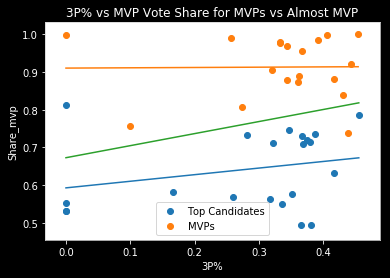

3PA


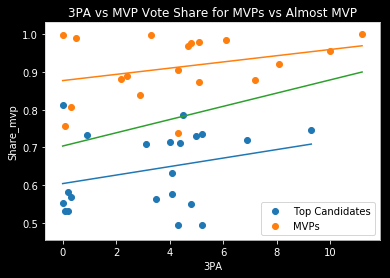

AST


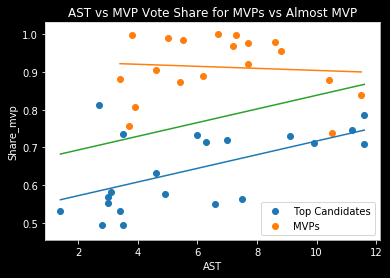

AST%


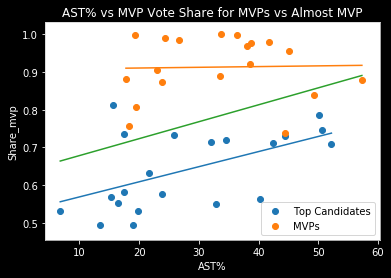

Age


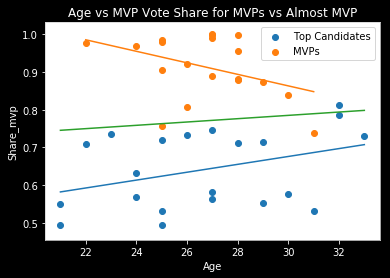

BLK


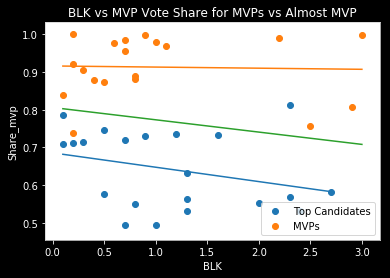

BLK%


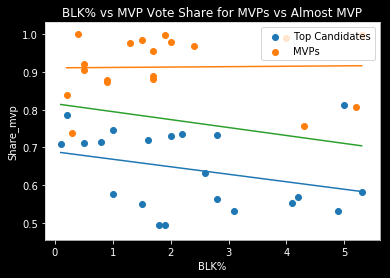

BPM


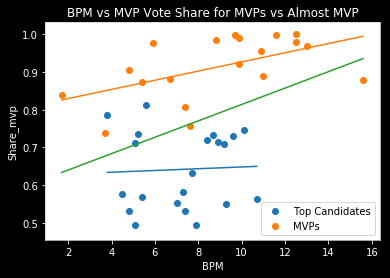

FG%


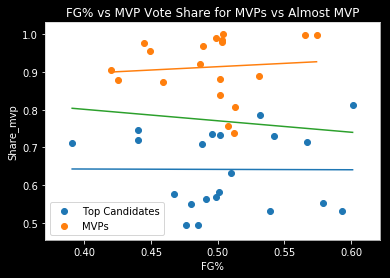

FGA


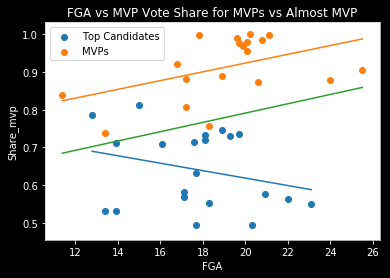

FT%


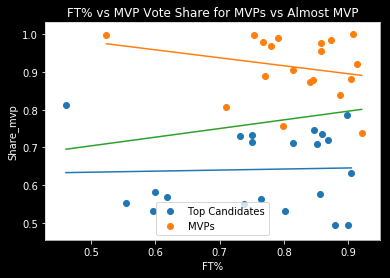

MP


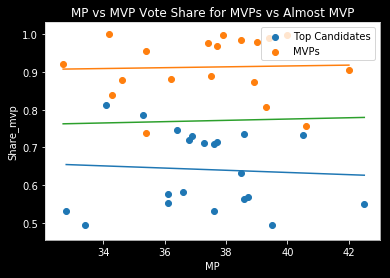

PER


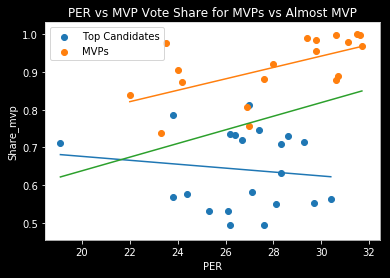

PF


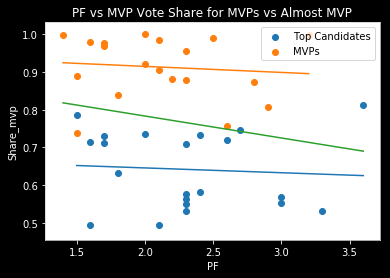

PTS


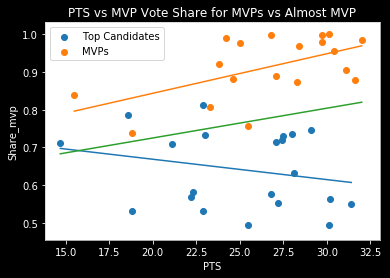

Rank_mip


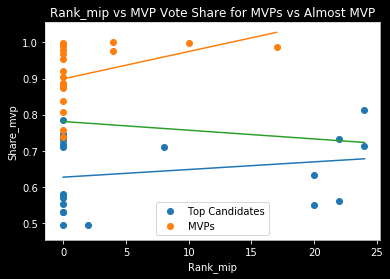

Rank_mvp


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RankWarning:

Polyfit may be poorly conditioned



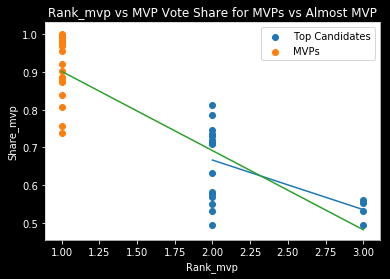

STL


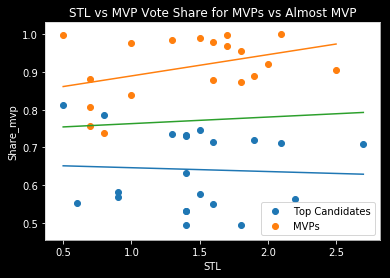

STL%


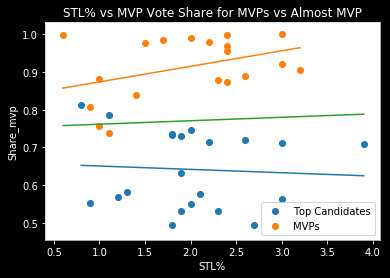

Share_mip


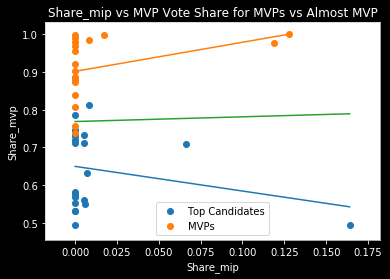

Share_mvp


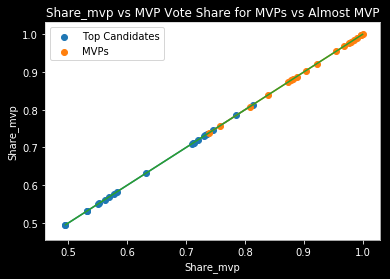

TOV


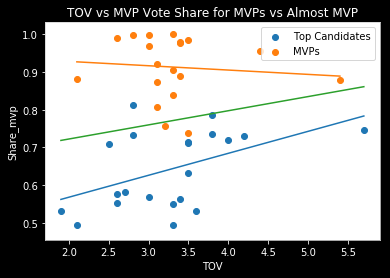

TOV%


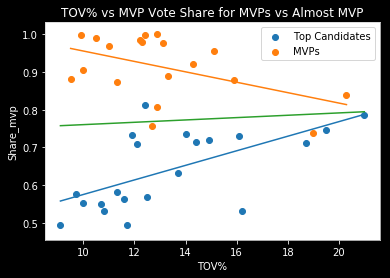

TRB


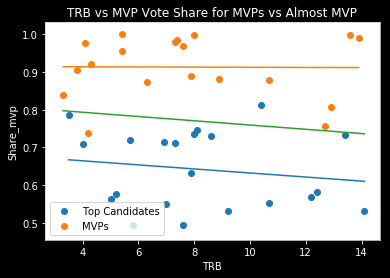

TRB%


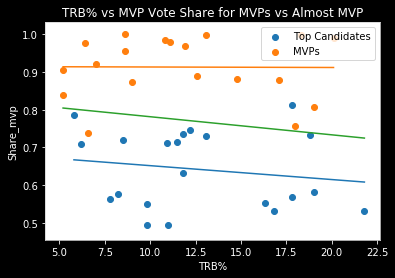

TS%


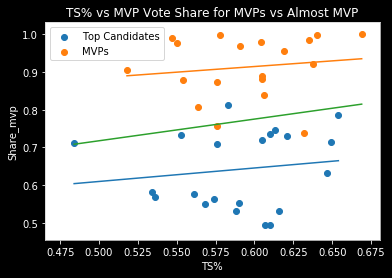

USG%


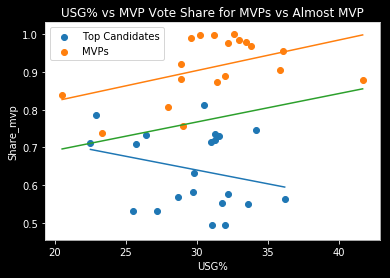

VORP


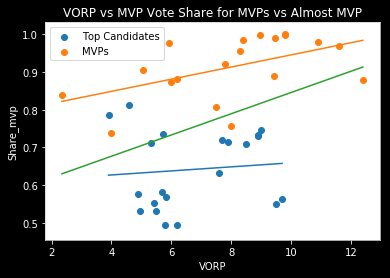

W/L%


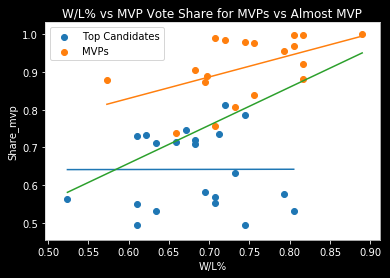

WS


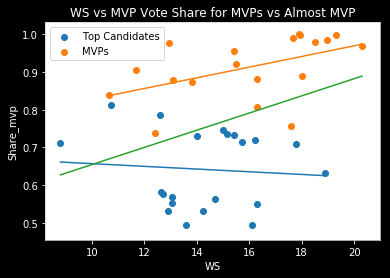

WS/48


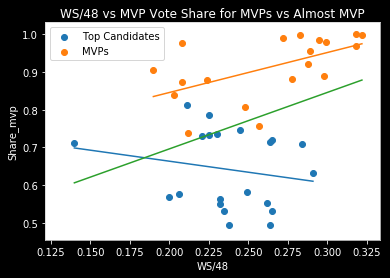

all_nba_1st


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RankWarning:

Polyfit may be poorly conditioned

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RankWarning:

Polyfit may be poorly conditioned

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RankWarning:

Polyfit may be poorly conditioned



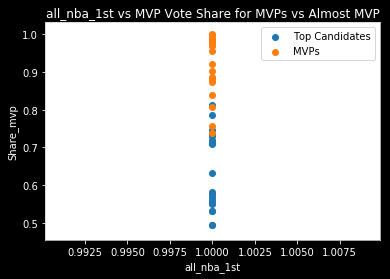

box


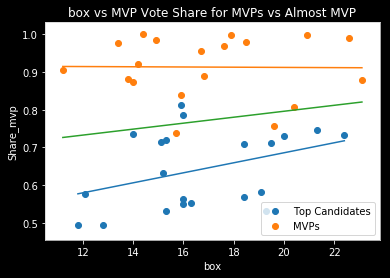

eFG%


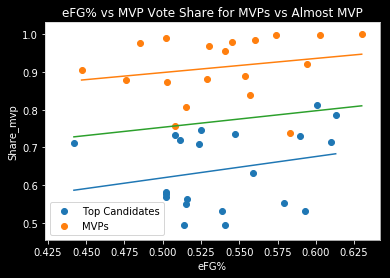

got_votes_mip


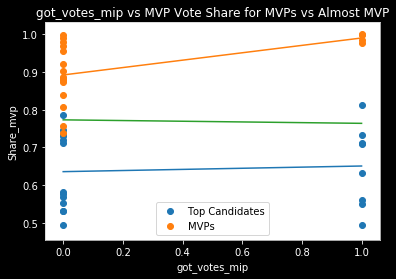

got_votes_mvp


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RankWarning:

Polyfit may be poorly conditioned

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RankWarning:

Polyfit may be poorly conditioned

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RankWarning:

Polyfit may be poorly conditioned



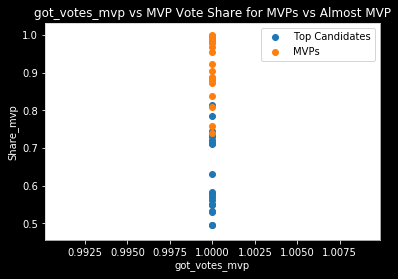

gp_pct


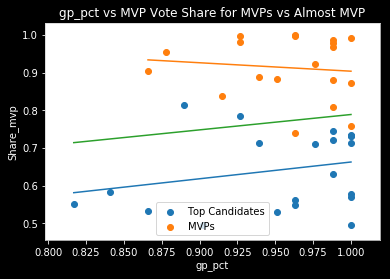

playoffs


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:42: RankWarning:

Polyfit may be poorly conditioned

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RankWarning:

Polyfit may be poorly conditioned

/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RankWarning:

Polyfit may be poorly conditioned



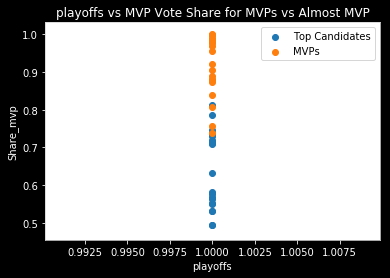

seed


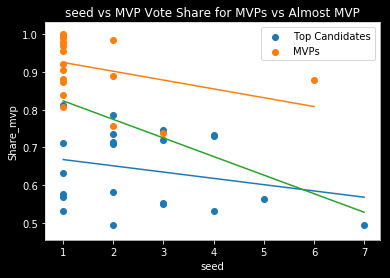

point_lead_count_wins


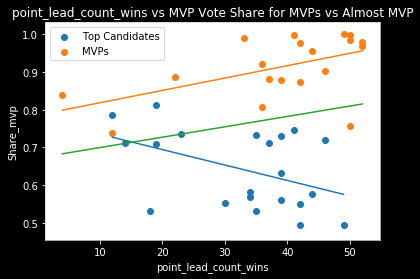

rebound_lead_count_wins


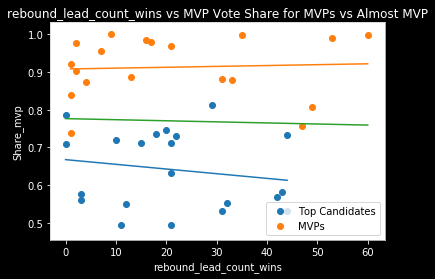

assist_lead_count_wins


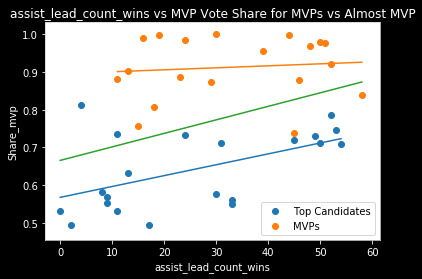

point_lead_count_losses


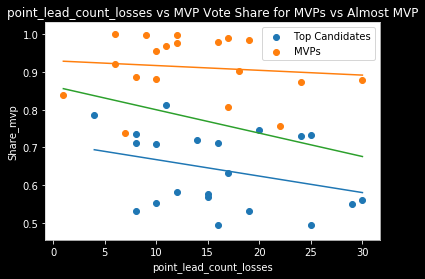

rebound_lead_count_losses


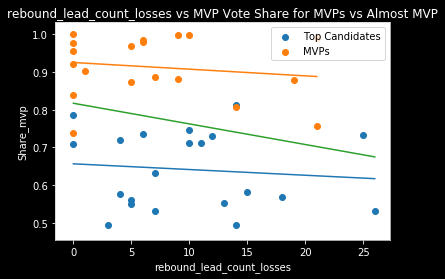

assist_lead_count_losses


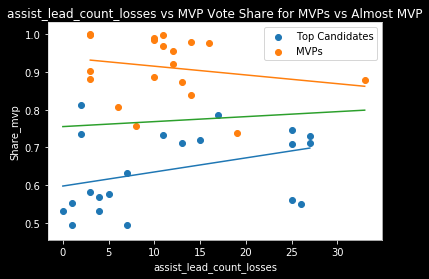

point_lead_count_total


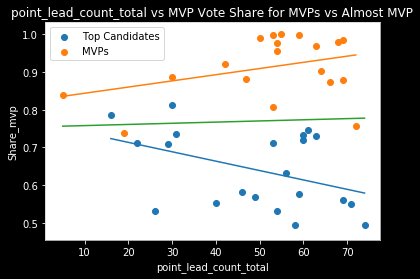

rebound_lead_count_total


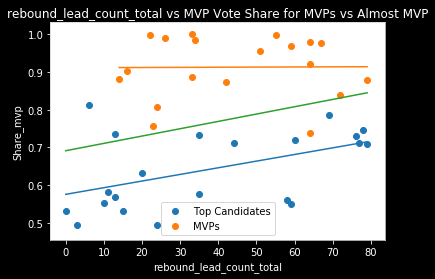

assist_lead_count_total


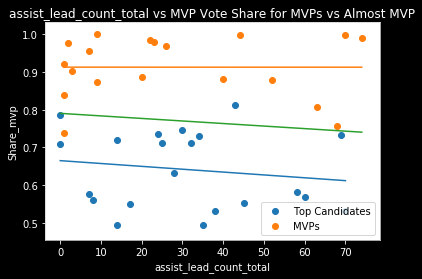

point_lead_rank


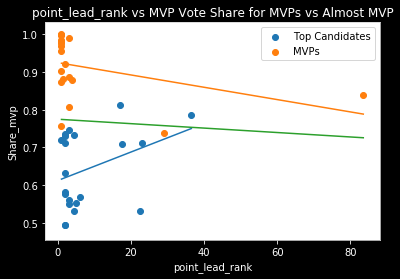

rebound_lead_rank


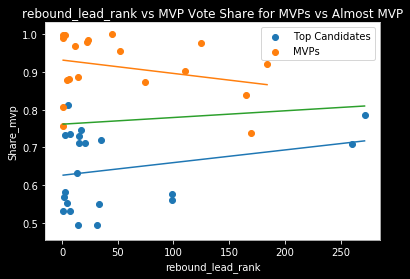

assist_lead_rank


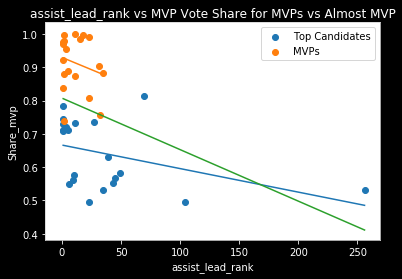

pra


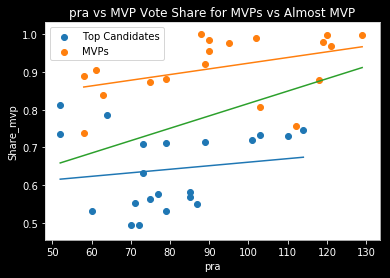

total_pra


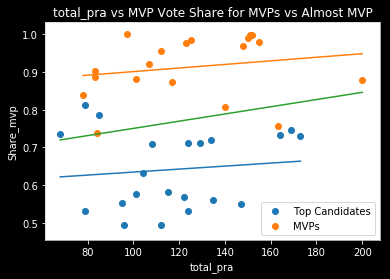

total_prank


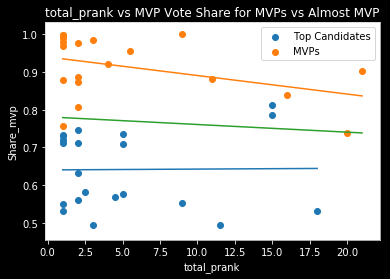

pra_rank


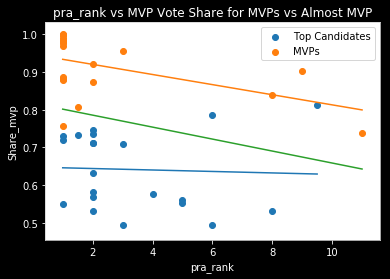

In [735]:
#Checking the difference between top candidates and MVPs for all our recorded stats

plt.rcParams.update({
"lines.color": "white",
"patch.edgecolor": "white",
"text.color": "black",
"axes.facecolor": "white",
"axes.edgecolor": "lightgray",
"axes.labelcolor": "white",
"xtick.color": "white",
"ytick.color": "white",
"grid.color": "lightgray",
"figure.facecolor": "black",
"figure.edgecolor": "black",
"savefig.facecolor": "black",
"savefig.edgecolor": "black"})

mvp_only = all_data_2000[all_data_2000['is_mvp']==1].drop(columns=["Tm","Year"])
top_candidate = all_data_2000[(all_data_2000['is_mvp']==0)&(all_data_2000['Share_mvp']>=.495)]#.drop(columns=["Tm","Year"]) #top candidate but not MVP - got at least 10% Vote Share
just2019=all_data_2000[all_data_2000["Year"]==2019]

for i in mvp_only.columns.drop(["Rank_roy","Rank_smoy","Rank_dpoy","Share_roy","Share_dpoy","Share_smoy",
                                "all_nba_2nd","all_nba_3rd",'all_rookie_1st','all_rookie_2nd','all_defense_1st',
                               'all_defense_2nd','got_votes_roy','got_votes_smoy','got_votes_dpoy','is_dpoy','is_smoy',
                               'is_roy','is_mip','is_mvp','is_rookie','rookie_pick']):
    print (i)
    #Just Top Candidates:
    x1=top_candidate[i].fillna(0)
    y1=top_candidate["Share_mvp"].fillna(0)
    
    #Just MVPs:
    x2=mvp_only[i].fillna(0)
    y2=mvp_only["Share_mvp"].fillna(0)
    
    # Line of best fit for top candidates including MVPs together
    x3=all_data_2000[all_data_2000['Share_mvp']>=.495][i].fillna(0)
    y3=all_data_2000[all_data_2000["Share_mvp"]>=.495]["Share_mvp"].fillna(0)
    
    plt.scatter(x1,y1,label="Top Candidates")
    plt.scatter(x2,y2,label="MVPs")
  
    plt.plot(np.unique(x1), np.poly1d(np.polyfit(x1, y1, 1))(np.unique(x1)))
    plt.plot(np.unique(x2), np.poly1d(np.polyfit(x2, y2, 1))(np.unique(x2)))
    plt.plot(np.unique(x3), np.poly1d(np.polyfit(x3, y3, 1))(np.unique(x3)))
    
    plt.xlabel(str(i))
    plt.ylabel("Share_mvp")
    plt.legend()
    plt.title(str(i)+" vs MVP Vote Share for MVPs vs Almost MVP",color="white")
    plt.show()
    

T test for 3P% Ttest_indResult(statistic=nan, pvalue=nan)


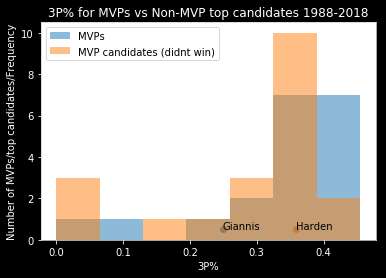

T test for 3PA Ttest_indResult(statistic=-1.101596802376297, pvalue=0.27756576834498004)


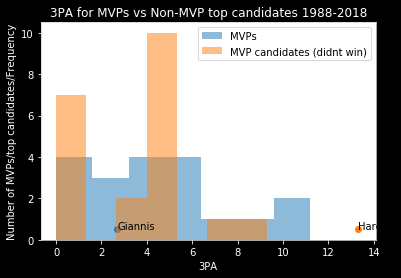

T test for AST Ttest_indResult(statistic=-0.9710629037002197, pvalue=0.3376577370079824)


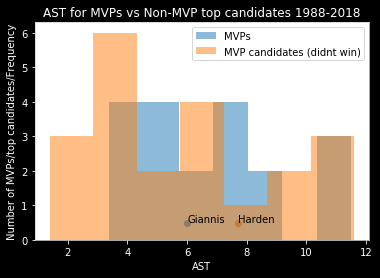

T test for AST% Ttest_indResult(statistic=-1.2146734366457532, pvalue=0.23198491180235156)


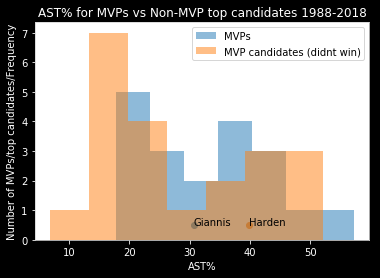

T test for Age Ttest_indResult(statistic=-0.023610146977348874, pvalue=0.981287126908517)


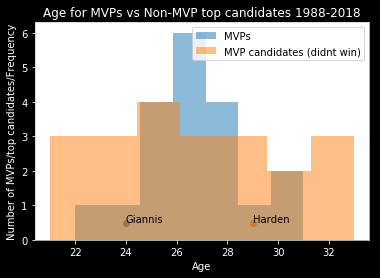

T test for BLK Ttest_indResult(statistic=0.5368857263085293, pvalue=0.5944763382701255)


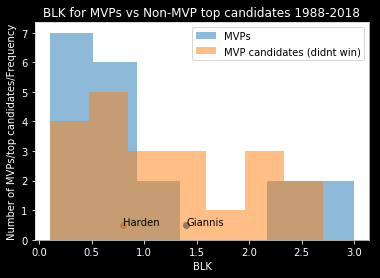

T test for BLK% Ttest_indResult(statistic=0.8277824582729537, pvalue=0.41296233176729047)


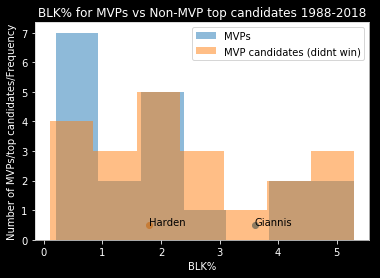

T test for BPM Ttest_indResult(statistic=-1.803753411164967, pvalue=0.07920225626996742)


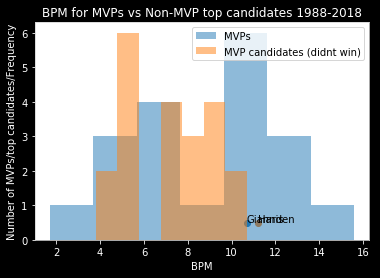

T test for FG% Ttest_indResult(statistic=0.7650284065878908, pvalue=0.44897999706491576)


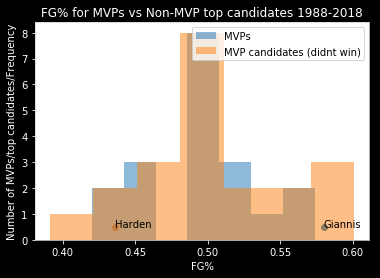

T test for FGA Ttest_indResult(statistic=-1.4956547140066923, pvalue=0.1430032184020211)


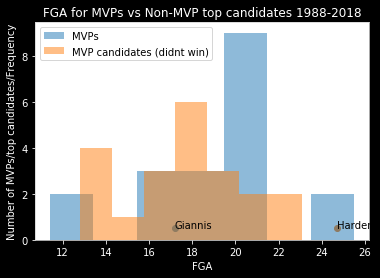

T test for FT% Ttest_indResult(statistic=-1.4663269498337055, pvalue=0.15078640377138633)


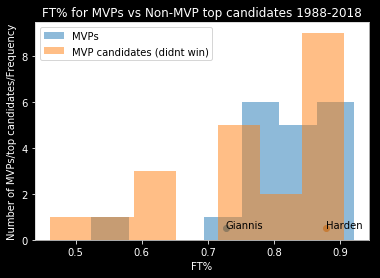

T test for MP Ttest_indResult(statistic=-0.2683798575026062, pvalue=0.7898585752085122)


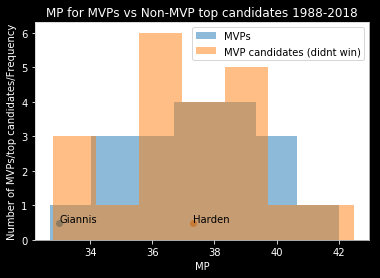

T test for PER Ttest_indResult(statistic=-1.5524357037741423, pvalue=0.12884779338155514)


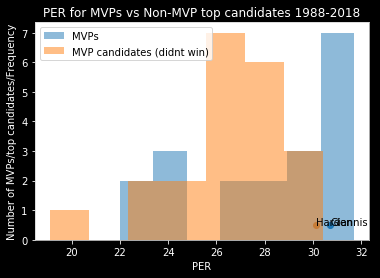

T test for PF Ttest_indResult(statistic=1.1179429562877765, pvalue=0.27060943760090866)


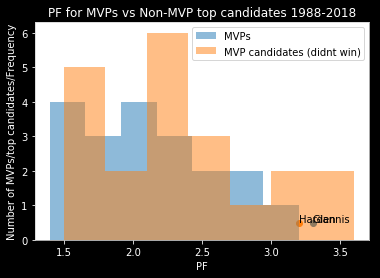

T test for PTS Ttest_indResult(statistic=-1.1786763307732382, pvalue=0.24585515058665744)


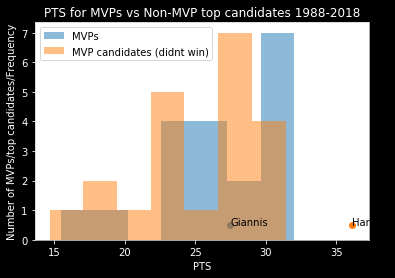

T test for Rank_dpoy Ttest_indResult(statistic=nan, pvalue=nan)


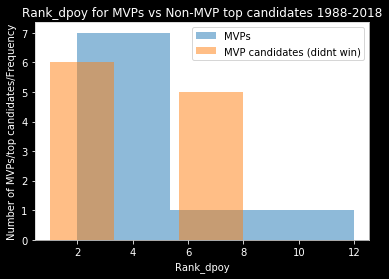

T test for Rank_mip Ttest_indResult(statistic=nan, pvalue=nan)


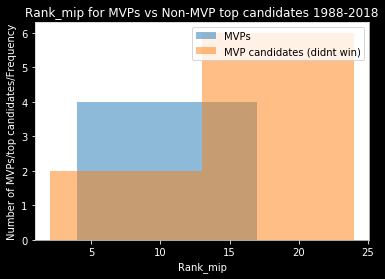

T test for Rank_mvp Ttest_indResult(statistic=12.880245932982712, pvalue=1.9429148071677895e-15)


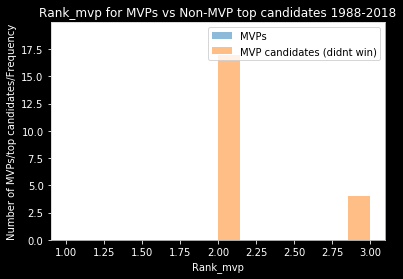

ALL MVPs have NAN for Rank_roy
ALL candidatess have NAN for Rank_roy
ALL MVPs have NAN for Rank_smoy
ALL candidatess have NAN for Rank_smoy
T test for STL Ttest_indResult(statistic=0.15555742736220218, pvalue=0.8772052928530971)


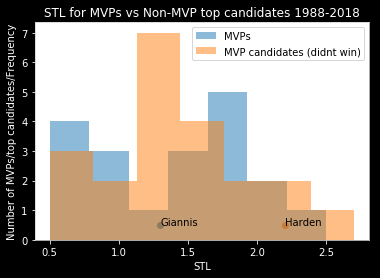

T test for STL% Ttest_indResult(statistic=0.23327684145894512, pvalue=0.8167985143465525)


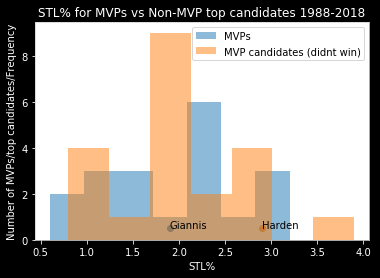

T test for Share_dpoy Ttest_indResult(statistic=1.079222080449636, pvalue=0.2872915204593748)


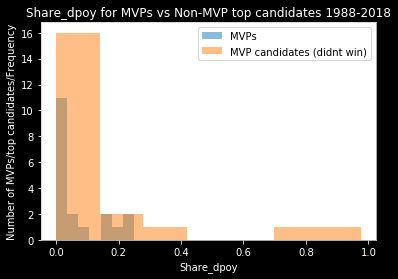

T test for Share_mip Ttest_indResult(statistic=-0.13676752925160274, pvalue=0.8919366057152665)


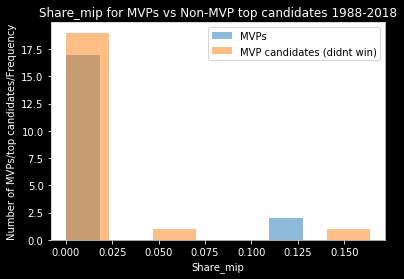

T test for Share_mvp Ttest_indResult(statistic=-9.163280545588377, pvalue=3.654614669431893e-11)


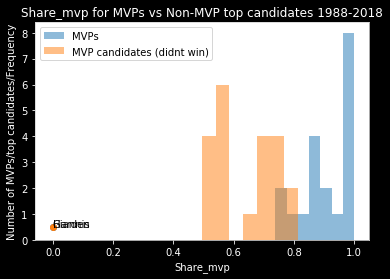

T test for Share_roy Ttest_indResult(statistic=nan, pvalue=nan)


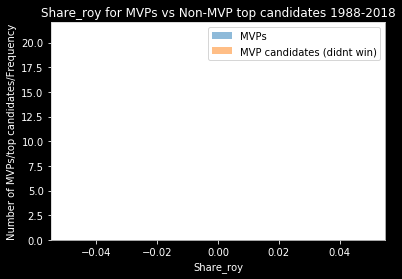

T test for Share_smoy Ttest_indResult(statistic=nan, pvalue=nan)


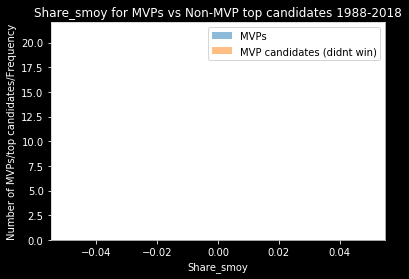

T test for TOV Ttest_indResult(statistic=-0.18228458795269864, pvalue=0.856328376611349)


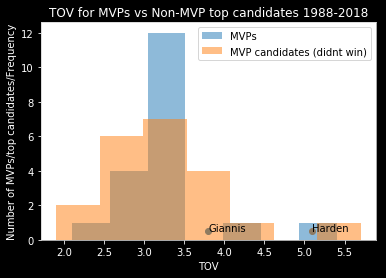

T test for TOV% Ttest_indResult(statistic=0.3653357052098809, pvalue=0.7168865559574107)


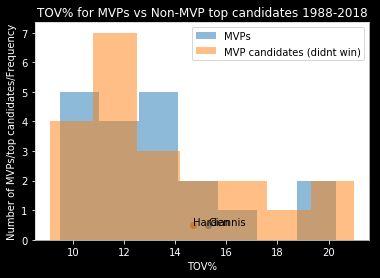

T test for TRB Ttest_indResult(statistic=0.4503851315743526, pvalue=0.6549919804321014)


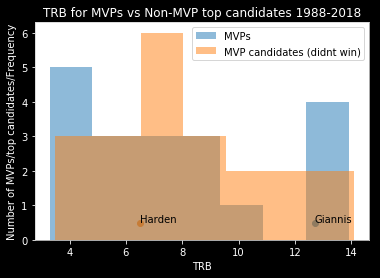

T test for TRB% Ttest_indResult(statistic=0.6266742286609068, pvalue=0.5346197900685429)


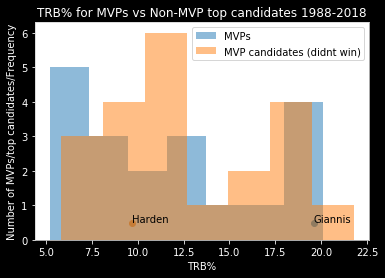

T test for TS% Ttest_indResult(statistic=-0.4400992644666402, pvalue=0.6623584122502075)


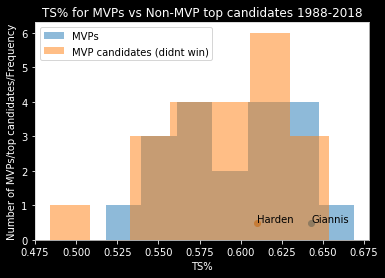

T test for USG% Ttest_indResult(statistic=-1.0607395688051946, pvalue=0.29550388561801044)


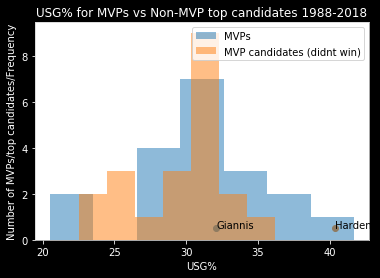

T test for VORP Ttest_indResult(statistic=-1.787117737074548, pvalue=0.0818973328427361)


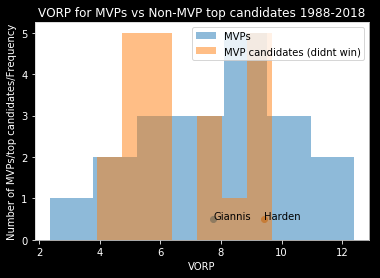

T test for W/L% Ttest_indResult(statistic=-2.933321281721289, pvalue=0.005656898483108994)


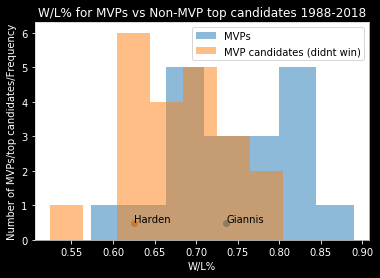

T test for WS Ttest_indResult(statistic=-2.1473722742164223, pvalue=0.03820558411091253)


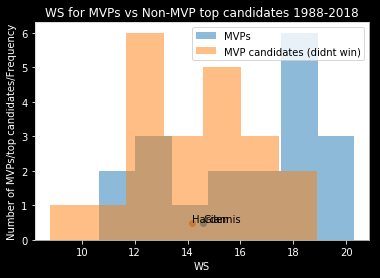

T test for WS/48 Ttest_indResult(statistic=-2.1587035993950923, pvalue=0.037253675019337996)


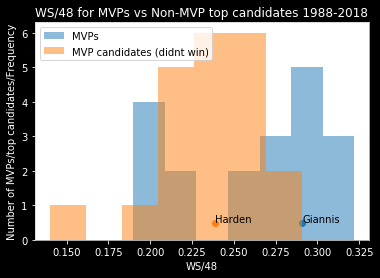

T test for all_defense_1st Ttest_indResult(statistic=-0.5600707502476975, pvalue=0.5787182002496671)


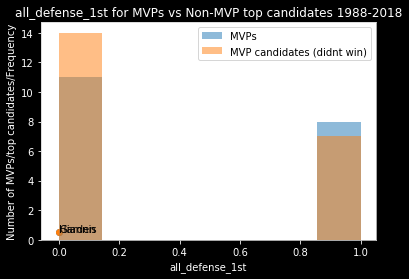

T test for all_defense_2nd Ttest_indResult(statistic=1.3117958618754415, pvalue=0.19745919414634333)


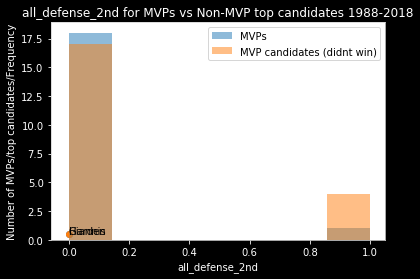

T test for all_nba_1st Ttest_indResult(statistic=nan, pvalue=nan)


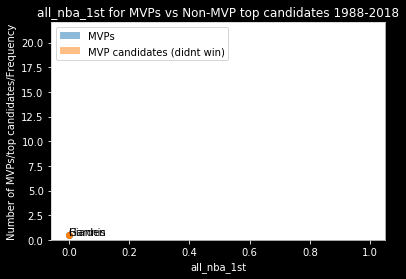

T test for all_nba_2nd Ttest_indResult(statistic=nan, pvalue=nan)


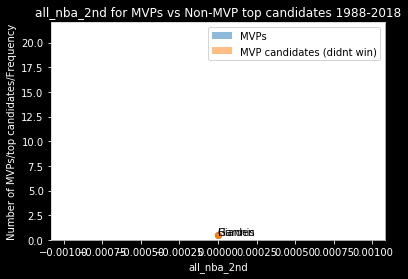

T test for all_nba_3rd Ttest_indResult(statistic=nan, pvalue=nan)


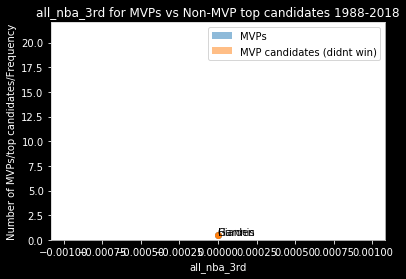

T test for all_rookie_1st Ttest_indResult(statistic=nan, pvalue=nan)


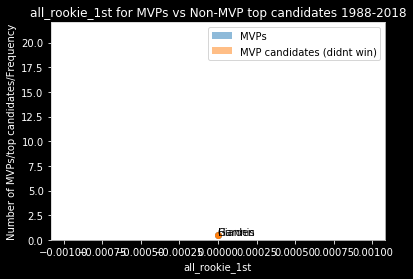

T test for all_rookie_2nd Ttest_indResult(statistic=nan, pvalue=nan)


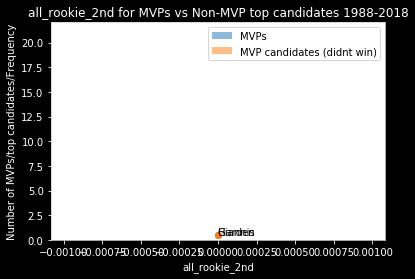

T test for box Ttest_indResult(statistic=-0.25572375598504565, pvalue=0.7995433613921875)


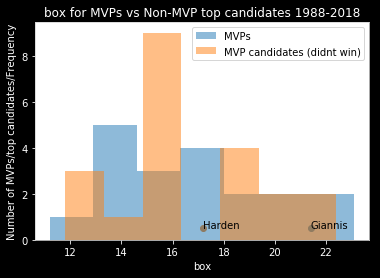

T test for eFG% Ttest_indResult(statistic=0.06454137307119145, pvalue=0.9488775052169526)


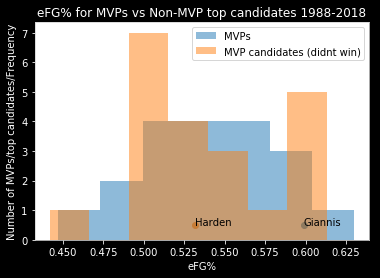

T test for got_votes_dpoy Ttest_indResult(statistic=0.30899415356066784, pvalue=0.7590138217667786)


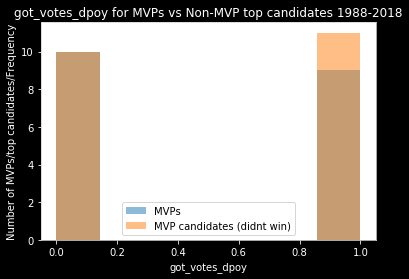

T test for got_votes_mip Ttest_indResult(statistic=1.1651087367091517, pvalue=0.2512369222537935)


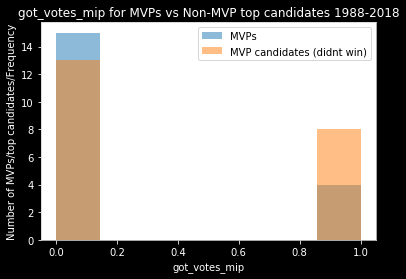

T test for got_votes_mvp Ttest_indResult(statistic=nan, pvalue=nan)


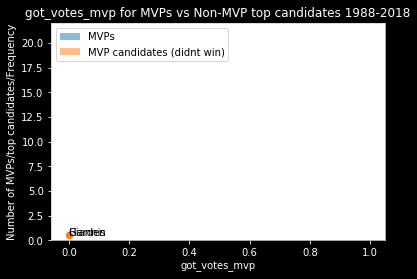

T test for got_votes_roy Ttest_indResult(statistic=nan, pvalue=nan)


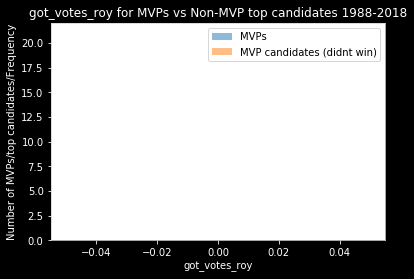

T test for got_votes_smoy Ttest_indResult(statistic=nan, pvalue=nan)


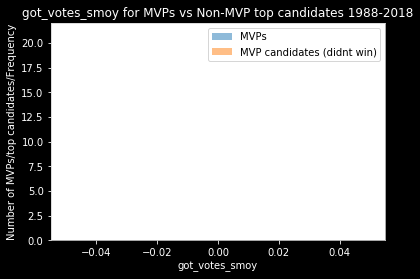

T test for gp_pct Ttest_indResult(statistic=-0.3775989209701837, pvalue=0.7078294663338098)


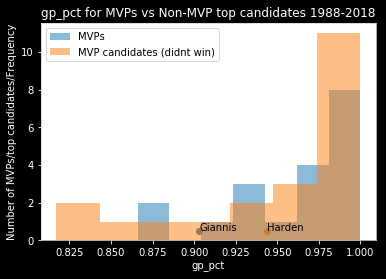

T test for is_dpoy Ttest_indResult(statistic=1.378404875209022, pvalue=0.1761401994713778)


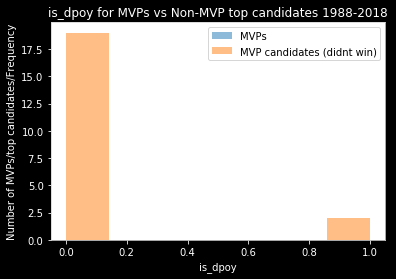

T test for is_mip Ttest_indResult(statistic=nan, pvalue=nan)


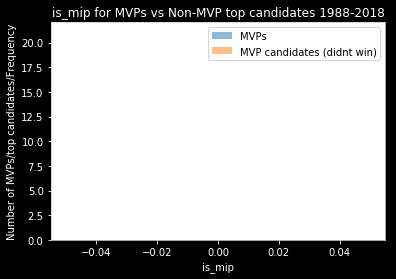

T test for is_mvp Ttest_indResult(statistic=-inf, pvalue=0.0)


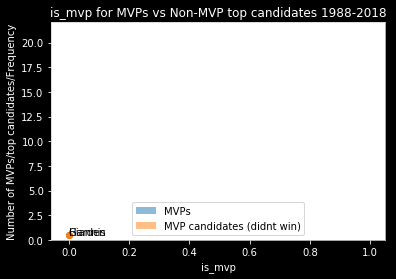

T test for is_rookie Ttest_indResult(statistic=nan, pvalue=nan)


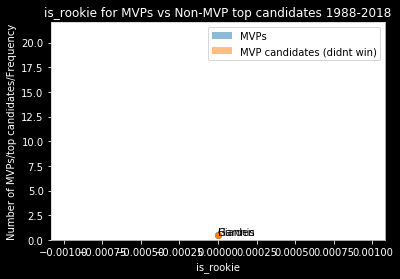

T test for is_roy Ttest_indResult(statistic=nan, pvalue=nan)


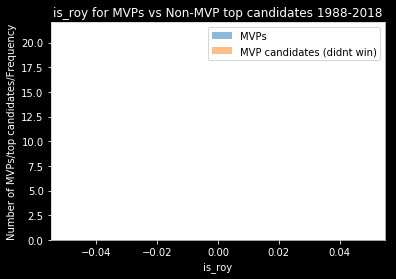

T test for is_smoy Ttest_indResult(statistic=nan, pvalue=nan)


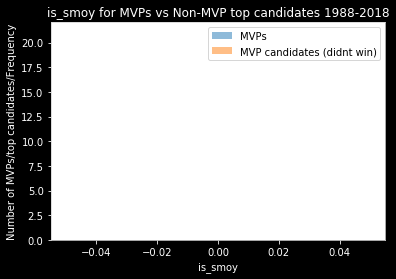

T test for playoffs Ttest_indResult(statistic=nan, pvalue=nan)


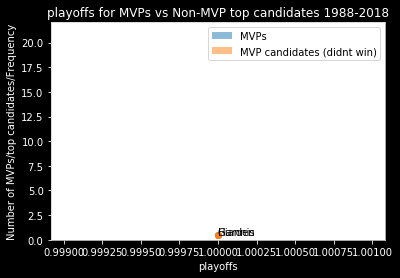

T test for rookie_pick Ttest_indResult(statistic=nan, pvalue=nan)


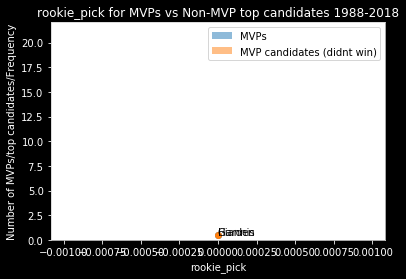

T test for seed Ttest_indResult(statistic=2.335869679186976, pvalue=0.024875271037802828)


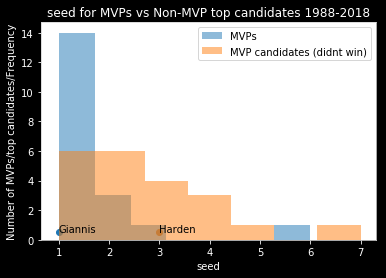

T test for point_lead_count_wins Ttest_indResult(statistic=-1.5267992577382719, pvalue=0.13509237254799886)


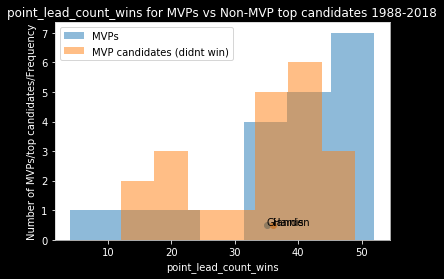

T test for rebound_lead_count_wins Ttest_indResult(statistic=-0.020244191723228677, pvalue=0.9839545024654008)


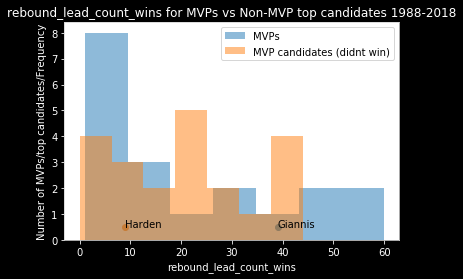

T test for assist_lead_count_wins Ttest_indResult(statistic=-1.3752497123301295, pvalue=0.17710811269338103)


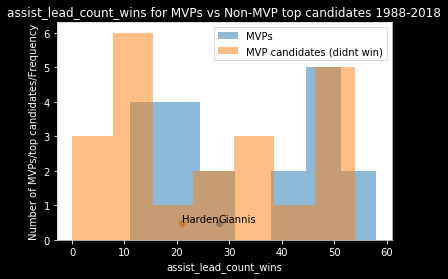

T test for point_lead_count_losses Ttest_indResult(statistic=1.1214332944497598, pvalue=0.2691403121110181)


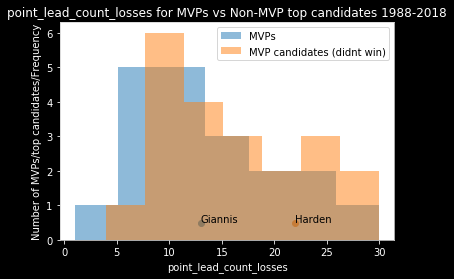

T test for rebound_lead_count_losses Ttest_indResult(statistic=1.2973757115190465, pvalue=0.20232333715150444)


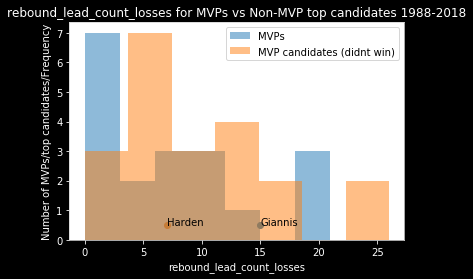

T test for assist_lead_count_losses Ttest_indResult(statistic=0.23452089588005856, pvalue=0.8158396904610313)


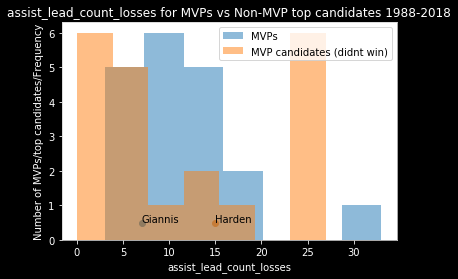

T test for point_lead_count_total Ttest_indResult(statistic=-0.598684764022419, pvalue=0.5529354553600359)


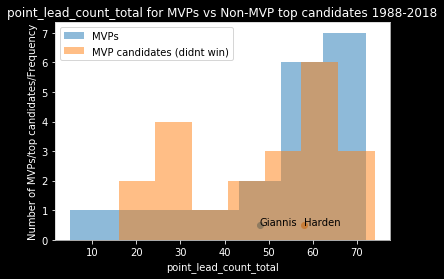

T test for rebound_lead_count_total Ttest_indResult(statistic=-0.8734713175832451, pvalue=0.3878928412102193)


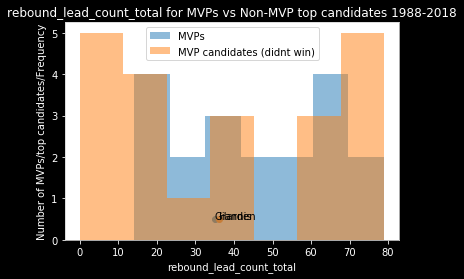

T test for assist_lead_count_total Ttest_indResult(statistic=0.37908105791695057, pvalue=0.7067376973535755)


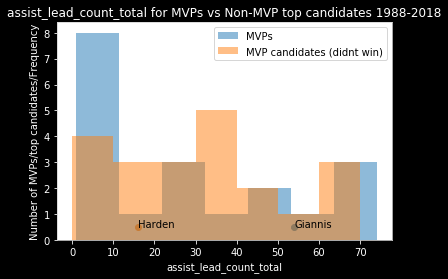

T test for point_lead_rank Ttest_indResult(statistic=0.07712407133588754, pvalue=0.9389295009143647)


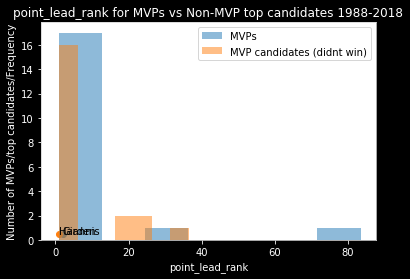

T test for rebound_lead_rank Ttest_indResult(statistic=-0.33669406768239973, pvalue=0.7381999775557438)


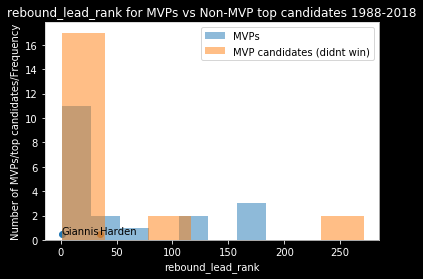

T test for assist_lead_rank Ttest_indResult(statistic=1.7658797596015552, pvalue=0.08545002200680989)


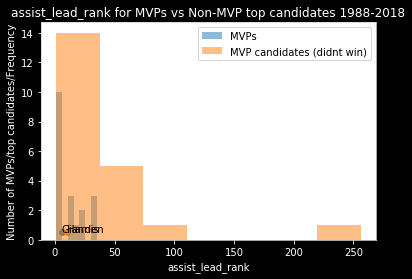

T test for pra Ttest_indResult(statistic=-2.1305991301947116, pvalue=0.03965410977815187)


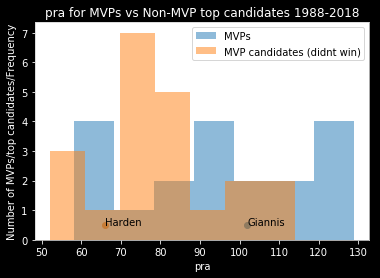

T test for total_pra Ttest_indResult(statistic=-0.7419529854309815, pvalue=0.4626773161061274)


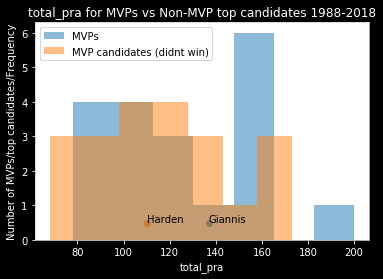

T test for total_prank Ttest_indResult(statistic=-0.2002393486413176, pvalue=0.8423612054739631)


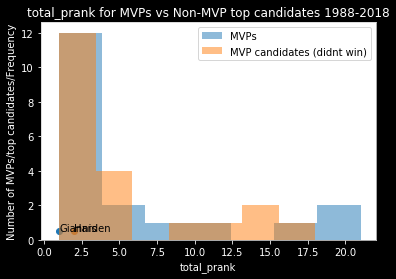

T test for pra_rank Ttest_indResult(statistic=0.8962483481839979, pvalue=0.37576296027710565)


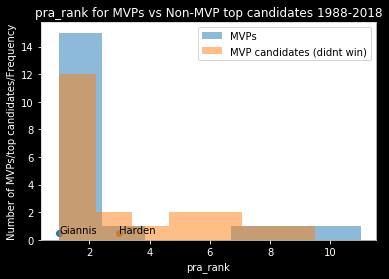

In [736]:
#Comparing top candidates to MVPs and t-tests for each stat, measuring the difference in the two groups
#in order to determine which variables are the best to include in the predictive model

from scipy.stats import ttest_ind

plt.rcParams.update({
"lines.color": "white",
"patch.edgecolor": "white",
"text.color": "black",
"axes.facecolor": "white",
"axes.edgecolor": "lightgray",
"axes.labelcolor": "white",
"xtick.color": "white",
"ytick.color": "white",
"grid.color": "lightgray",
"figure.facecolor": "black",
"figure.edgecolor": "black",
"savefig.facecolor": "black",
"savefig.edgecolor": "black"})

mvp_only = all_data_2000[all_data_2000['is_mvp']==1].drop(columns=["Tm","Year"])
top_candidate = all_data_2000[(all_data_2000['is_mvp']==0)&(all_data_2000['Share_mvp']>=.495)]#.drop(columns=["Tm","Year"]) #top candidate but not MVP - got at least 10% Vote Share
just2019=all_data_2000[all_data_2000["Year"]==2019]

for i in mvp_only.columns:
    is_graph=0
    if not pd.isnull(mvp_only[i]).all():
        plt.hist(mvp_only[i].dropna(),bins = np.linspace(mvp_only[i].min(), mvp_only[i].max(),round(len(mvp_only[i].dropna())*.4)), label='MVPs',alpha=0.5)
        if not pd.isnull(just2019.loc["Giannis Antetokounmpo"][i]):
            plt.scatter(just2019.loc["Giannis Antetokounmpo"][i],0.5)
            plt.annotate("Giannis",(just2019.loc["Giannis Antetokounmpo"][i],0.5))
        if not pd.isnull(just2019.loc["James Harden"][i]):
            plt.scatter(just2019.loc["James Harden"][i],0.5)
            plt.annotate("Harden",(just2019.loc["James Harden"][i],0.5))
            is_graph=1
    else: print ("ALL MVPs have NAN for",i)
    if not pd.isnull(top_candidate[i]).all():
        plt.hist(top_candidate[i].dropna(), bins = np.linspace(top_candidate[i].min(), top_candidate[i].max(),round(len(top_candidate[i].dropna())*.4)), label='MVP candidates (didnt win)',alpha=0.5)
        is_graph=1
        print ("T test for",i,ttest_ind(top_candidate[i], mvp_only[i]))
    else: print ("ALL candidatess have NAN for",i)
    if is_graph==1:
        plt.title(str(i)+" for MVPs vs Non-MVP top candidates 1988-2018",color='white')
        plt.xlabel(str(i))
        plt.legend()
        plt.ylabel("Number of MVPs/top candidates/Frequency")
        plt.show()


In [737]:
#Results p<.13:
#T test for pra Ttest_indResult(statistic=-2.13, pvalue=0.039)
#T test for seed Ttest_indResult(statistic=2.3, pvalue=0.024)
#T test for WS/48 Ttest_indResult(statistic=-2.1, pvalue=0.037)
#T test for WS Ttest_indResult(statistic=-2.1, pvalue=0.038)
#T test for W/L% Ttest_indResult(statistic=-2.93, pvalue=0.006)
#T test for VORP Ttest_indResult(statistic=-1.79, pvalue=0.082)
#T test for PER Ttest_indResult(statistic=-1.55, pvalue=0.129)
#T test for BPM Ttest_indResult(statistic=-1.8, pvalue=0.079)


In [738]:
#LOGISTIC REGRESSION Prediction as function With LeaderStats included (as P.R.A)
def logistic2000_MVP(year):
    
    X = all_data_2000[(all_data_2000.Year!=2019)&(all_data_2000.Year!=year)][['WS','PER','pra','seed','W/L%','VORP','BPM']]
    y = all_data_2000[(all_data_2000.Year!=2019)&(all_data_2000.Year!=year)]["is_mvp"]
    
    X_test = all_data_2000[all_data_2000.Year==year][['WS','PER','pra','seed','W/L%','VORP','BPM']]    
    y_test = all_data_2000[all_data_2000.Year==year]['is_mvp']
    
    clf = LogisticRegression(C=.3,random_state=0,solver='lbfgs',multi_class='multinomial').fit(X, y)

    logistic_probs = clf.predict_proba(X_test)[:,1]
    outcome_df = all_data_2000[all_data_2000.Year==year][['WS','PER','pra','seed','W/L%','VORP','BPM',"Year","is_mvp"]]
    outcome_df['Logistic Prediction']=(clf.predict(X_test))
    outcome_df['confidence score']=(clf.decision_function(X_test))
    outcome_df['Logistic Probability (%)']=logistic_probs.astype(float)
    outcome_df=outcome_df.round(3)
    outcome_df=outcome_df.sort_values('Logistic Probability (%)',ascending=False)
    if outcome_df[outcome_df.is_mvp==1].index[0] == outcome_df["Logistic Probability (%)"].idxmax():
        print("Hallelujah! we produced a CORRECT prediction with confidence",outcome_df['confidence score'][0], "in",year)
    else:
        print ('...better luck next year predicting',outcome_df[outcome_df.is_mvp==1].index[0],year)
        print ('true MVPs predicted chance of winning:',
               outcome_df["Logistic Probability (%)"][outcome_df[outcome_df.is_mvp==1].index[0]])
    print()
    return outcome_df[:10]
    
for year in range(2000,2019):
    logistic2000_MVP(year)

Hallelujah! we produced a CORRECT prediction with confidence 1.932 in 2000

...better luck next year predicting Allen Iverson 2001
true MVPs predicted chance of winning: 0.165

Hallelujah! we produced a CORRECT prediction with confidence 0.516 in 2002

Hallelujah! we produced a CORRECT prediction with confidence 0.604 in 2003

Hallelujah! we produced a CORRECT prediction with confidence 0.965 in 2004

...better luck next year predicting Steve Nash 2005
true MVPs predicted chance of winning: 0.097

...better luck next year predicting Steve Nash 2006
true MVPs predicted chance of winning: 0.055

Hallelujah! we produced a CORRECT prediction with confidence -0.264 in 2007

...better luck next year predicting Kobe Bryant 2008
true MVPs predicted chance of winning: 0.286

Hallelujah! we produced a CORRECT prediction with confidence 1.934 in 2009

Hallelujah! we produced a CORRECT prediction with confidence 1.838 in 2010

Hallelujah! we produced a CORRECT prediction with confidence -0.441 in 

...better luck next year predicting Michael Jordan 1988
true MVPs predicted chance of winning: 0.462

MVP in 1988 Predicted incorrectly as Larry Bird . The correct MVP was  Michael Jordan


/Users/crazyforcandy1234/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



KeyError: 'Share_mvp'

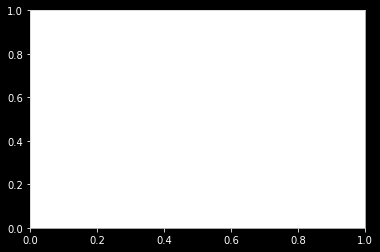

In [739]:
# SVM Regression Prediction results plotted:

import matplotlib
from matplotlib.lines import Line2D

def plot_prediction(year):
    df=logisticMVP(year)
    fig, ax = plt.subplots()
    if df.loc[df['Logistic Probability (%)'].idxmax()]['is_mvp']==1:
        print ("MVP in",year,"Predicted correctly")
        color=df['is_mvp']
        
    else:
        print ("MVP in",year,"Predicted incorrectly as",df['Logistic Probability (%)'].idxmax(),
              ". The correct MVP was ",df['is_mvp'].idxmax())
        df['color']=df['is_mvp']
        df['color'][df['Logistic Probability (%)'].idxmax()]=-3
        color=df['color']
    df.loc[df['Logistic Probability (%)'].idxmax()]
    ax.scatter(df['Share_mvp'],df['SVM Prediction'],c=color,label=color)
    #ax.legend(['MVP','Predicted MVP'],loc='upper left')
    
    #legend_elements = [Line2D([0], [0], marker='o',color='w', label='MVP',
                            # markerfacecolor='purple',markersize=8),
                   #Line2D([0], [0], marker='o', color='w', label='Predicted MVP',
                          #markerfacecolor='y',markersize=8)]
    #ax.legend(handles=legend_elements, loc='upper_left')


    for i, txt in enumerate(df.index):
        ax.annotate(txt, (df['Share_mvp'][i],df['SVM Prediction'][i]))
    
    plt.xlabel("Actual MVP Vote Share")
    plt.ylabel("Logistic Probability Estimate of binary outcome")
    plt.title("MVP SVM Predictions vs Reality in "+ str(year))

for i in range (1988,2019):
    plot_prediction(i)

In [ ]:
#interpretation, observations
#bad years for prediction: 2017, 2011, 2008, 2006, 2005, 2001, 1998
#2005 and 1999 might have been messed up because they need adjustment for lockout (fewer than 82 games)

In [ ]:
# Taking a closer look at pra rank, we see the MVP's fare well in this stat. This likely means something!
mvp_only["pra_rank"]

In [ ]:
plt.scatter(top_candidate["Share_mvp"],top_candidate["pra"],label="Top Candidates")
plt.scatter(mvp_only["Share_mvp"],mvp_only["pra"],label="MVPs")
plt.xlabel("Vote Share")
plt.ylabel("PRA")
plt.legend()
plt.title("Vote Share and PRA for MVPs vs Almost MVP",color='white')
plt.show()

In [ ]:
#Showing the intersection between vote share overlap between MVPs and top candidates

i="Share_mvp"
plt.hist(mvp_only[i].dropna(),bins = np.linspace(mvp_only[i].min(), mvp_only[i].max(),round(len(mvp_only[i].dropna())*.4)), label='MVPs',alpha=0.5)
plt.hist(top_candidate[i].dropna(), bins = np.linspace(top_candidate[i].min(), top_candidate[i].max(),round(len(top_candidate[i].dropna())*.4)), label='MVP candidates (didnt win)',alpha=0.5)
plt.title(str(i)+" for MVPs vs Non-MVP top candidates 1988-2018",color='white')
plt.xlabel(str(i))
plt.axvline(label='Fuzzy cutoff',x=min(mvp_only[i]),linestyle='dashed',color='green')
plt.axvline(label='Fuzzy cutoff',x=max(top_candidate[i]),linestyle='dashed',color='green')
plt.legend()
plt.ylabel("Number of MVPs/top candidates/Frequency")
plt.show()

print (len(top_candidate[top_candidate["Share_mvp"]<min(mvp_only["Share_mvp"])]))
#18 top candidates in left part; 3 candidates in MVP/mix range

print (len(mvp_only[mvp_only["Share_mvp"]>max(top_candidate["Share_mvp"])]))
#16 MVPs in right part; 3 MVP's in candidate/mix range


In [ ]:
#Showing leaderstat ranks for top candidates

ok=all_data_2000[all_data_2000["Year"]!=2019].sort_values("Year",ascending=False)
ok['point_lead_rank']=ok.groupby('Year')['point_lead_count_wins'].rank(ascending=False)
ok['rebound_lead_rank']=ok.groupby('Year')['rebound_lead_count_wins'].rank(ascending=False)
ok['assist_lead_rank']=ok.groupby('Year')['assist_lead_count_wins'].rank(ascending=False)
ok_candidates=ok[(ok['is_mvp']==0)&(ok["Share_mvp"]>.5)]
ok_candidates.index.name="candidate"
ok_candidates[['Year','point_lead_rank','rebound_lead_rank','assist_lead_rank','Share_mvp']]

In [ ]:
#Showing leaderstat ranks for MVPs

ok_mvp=ok[ok['is_mvp']==1]
ok_mvp.index.name="MVP"
ok_mvp[['Year','point_lead_rank','rebound_lead_rank','assist_lead_rank']]